# Imports and function definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import read_data as rd
import scipy.stats as ss
import scipy.fftpack as fft
import scipy.signal as ssi
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas
import cartopy
pd.options.display.max_columns = 999
pd.options.display.max_rows = 77
from shapely.geometry import Point
import shapely.ops as shops

%matplotlib inline

## Collating data

In [2]:
def add_counts(crime_df, crime_type=None):
    """Add the counts by function of hour, day, month, and year
    
    If crime_type is None, then all crimes. Otherwise, for crime_type only"""
    
    crime_count_dict = {}
    
    if crime_type is not None and str.lower(crime_type) != 'all':
        crime_df = crime_df[crime_df['Primary Type'] == str.upper(crime_type)]
    
    if len(crime_df) == 0:
        raise KeyError('Invalid crime type')
    
    crime_count_dict['hour'] = crime_df.index.hour.value_counts().astype(float)
    crime_count_dict['weekday'] = crime_df.index.weekday.value_counts().astype(float)
    crime_count_dict['day'] = crime_df.index.day.value_counts().astype(float)
    crime_count_dict['month'] = crime_df.index.month.value_counts().astype(float)
    crime_count_dict['year'] = crime_df.index.year.value_counts().astype(float)
    
    return crime_count_dict

## Plot counts

In [3]:
def plot_counts(counts, ax, weights=None, bar=True, do_err=False, **kwargs):
    """Provide bar position and heights for crime counts
    
    if weights is not None, weightsalize 
    If bar false, do a line plot
    """
    xs = counts.index
    vals = counts.values / counts.values.sum()
    
    if weights is not None:
        try:
            vals *= weights
        except TypeError:
            if weights.lower() == 'month':
                weights = 1. / np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) * 30. 
                #technically Feb is 28.25?
            elif weights.lower() == 'day':
                weights = np.ones(31)
                weights[30] = 12./7
                weights[29] = 12./11
                weights[28] = 12./11
            else:
                print(f'Unrecognized weights: {weights}')
                weights = np.ones(len(xs))
            assert len(weights) == len(xs)
            vals *= weights
    if bar:
        ax.bar(xs, vals, **kwargs)
    else:
        if do_err:
            ax.errorbar(np.sort(xs), vals[np.argsort(xs)], yerr=np.sqrt(counts.values)/counts.values.sum(), **kwargs)
        else:
            ax.plot(np.sort(xs), vals[np.argsort(xs)], **kwargs)

## Plot map

In [4]:
def plot_crime_map(crime_df, geo_df, census_df, year, crime_type, cmap='Blues', annotate=False,
                  num_annotations=(3, 3), annot_colors=('black', 'black'), filename=None, **kwargs):
    """Plot the crime rate by neighborhood
    
    crime_df : the crime dataframe
    geo_df : the geopandas dataframe, for drawing the map
    census_df : the census dataframe
    year : either one year or a range of years, inclusively, (min_year, max_year)
    crime_type : the type of crime to consider
    cmap (default 'Blues') : the colormap to use
    annotate (default False) : whether to label the highest and/or lowest crime neighborhoods, using
        the remaining arguments as guide
    num_annotations (default (3, 3)) : 2-tuple with (num_low, num_high), the number of neighborhoods to
        label with the lowest and highest crime rates, respectively
    annot_colors (default ('black', 'black')) : 2-tuple with colors to use to plot low and high neighborhoods
    filename (default None) : save the figure to the path given by filename
    
    **kwargs
    vmax - maximum of colorbar
    """
    
    try:
        a = len(year)
    except TypeError:
        year = [year]
    
    if len(year) == 1:
        subview = crime_df.loc[crime_df['Year'] == year[0]]
    elif len(year) == 2:
        subview = crime_df.loc[(crime_df['Year'] >= year[0]) & (crime_df['Year'] <= year[1])]
    else:
        raise ValueError('Too many years!')
        
    neighborhood_counts = (subview[subview['Primary Type'] == crime_type.upper()]['Community Area']
                                                .value_counts(sort=False))
    neighborhood_counts = neighborhood_counts.reindex(index=geo_df['area_num_1'].astype(int), fill_value=0)
    neighborhood_rates = (1e5 * neighborhood_counts / census_df['Total Population'] / len(subview['Year']
                                                .value_counts()))

    cmap1 = plt.cm.ScalarMappable(cmap=cmap)
    if 'vmax' in kwargs:
        cmap1.set_clim(0, kwargs['vmax'])
    else:
        cmap1.set_clim(0, neighborhood_rates.max())

    ax = geo_df.plot(edgecolor='k', 
                    facecolor=cmap1.to_rgba(neighborhood_rates.loc[geo_df['area_num_1'].astype(int)]), 
                    figsize=(10, 8))
    
    fig = ax.get_figure()
    cax = fig.add_axes([0.88, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(cmap1, cax=cax)
    if len(year) > 1:
        year_label = f'{year[0]} to {year[1]}'
    else:
        year_label = f'{year[0]}'
    cbar.set_label(f'{crime_type.title()} per 100k people per year, ' + year_label, 
                   rotation=270, fontsize=20, labelpad=20)
    ax.set_xlim([-88, -87.5])
    ax.set_ylim([41.6, 42.05])
    
    if annotate:
        # lowest crime rate not necessarily unique if there are multiple zeros
        annotate_inds = []
        annotate_inds += list(np.arange(num_annotations[0]))
        annotate_inds += list(np.arange(-num_annotations[1], 0))
        to_annotate = neighborhood_rates.sort_values().iloc[annotate_inds]
        if len(to_annotate) > 0:
            # location of neighborhood centers
            xys = np.array([[geo_df[geo_df['area_num_1'] == neighborhood].centroid.x.values[0], 
                   geo_df[geo_df['area_num_1'] == neighborhood].centroid.y.values[0]]
                   for neighborhood in to_annotate.index])
            second_leg = []
            for i, (x, y) in enumerate(xys):
    #             ax.text(x, y, geo_df[geo_df['area_num_1'] == to_annotate.index[i]]['community'].values[0].title())
                ax.scatter(x, y, marker=f'${to_annotate.index[i]}$', 
                                  color=annot_colors[0 if i<num_annotations[0] else 1], 
                                  s=50 if to_annotate.index[i] < 10 else 100)
                # this one is just for the legend, to make sure the marker is black and legible
                scat = ax.scatter([], [], marker=f'${to_annotate.index[i]}$', color='black',
                                  s=100 if to_annotate.index[i] < 10 else 200,
                                  label=geo_df[geo_df['area_num_1'] 
                                   == to_annotate.index[i]]['community'].values[0].title()
                          + f', {neighborhood_rates.loc[to_annotate.index[i]]:.1f}')
                if i == num_annotations[0] - 1:
                    leg = ax.legend(loc='center left', 
                                    title=f'Lowest Crime Area\nID Number, Name, {crime_type.title()}/100k',
                                   fontsize=12, title_fontsize=12)
                    ax.add_artist(leg)
                    continue
                if i >= num_annotations[0]:
                    second_leg.append(scat)
                if i == len(xys) - 1:
                    ax.legend(handles=second_leg, loc='lower left', 
                              title=f'Highest Crime Area\nID Number, Name, {crime_type.title()}/100k',
                             fontsize=12, title_fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight')

## Plot PSD 

In [5]:
def crime_periodogram(crime_df, crime_type=None, ax=None, plot_trends=False):
    """Estimate the power spectral density of crime.
    
    Use Welch's method to estimate the PSD of crimes.
    
    crime_df : the crime dataframe
    crime_type (default None) : the type of crime to consider, or all crimes
    ax (default None) : if not None, the axis on which to plot
    plot_trends (default False) : if True, plot the data and detrended data
    """
    
    if crime_type is not None and str.lower(crime_type) != 'all':
        crime_df = crime_df[crime_df['Primary Type'] == str.upper(crime_type)]
        
    # resampling crimes into daily counts
    crime_days = (crime_df.index - pd.to_datetime('Jan 01 2001')).days.value_counts().sort_index()
    
    X_to_fit = crime_days.index.values[np.newaxis, :].transpose()
    background = LinearRegression().fit(X_to_fit,
                                       crime_days.values[np.newaxis, :].transpose())
    
    detrended_crime_days = crime_days - background.predict(X_to_fit).transpose()[0]

    if plot_trends:
        fig_temp, ax_temp = plt.subplots(2, 1, sharex=True)
        fig_temp.subplots_adjust(hspace=0)
        fig_temp.set_size_inches(10, 10)
        ax_temp[0].plot(crime_days, label='Data')
        ax_temp[0].plot(X_to_fit.transpose()[0], background.predict(X_to_fit).transpose()[0], 
                label='Trend Fit', lw=3)
        ax_temp[0].legend(fontsize=14)
        ax_temp[1].axhline(0, color='black', ls='--')
        ax_temp[1].plot(detrended_crime_days, label='Detrended Data')
        ax_temp[1].set_ylabel('Residual', fontsize=14)
        ax_temp[1].set_xlabel('Days', fontsize=14)
        ax_temp[0].set_ylabel('N', fontsize=14)
        ax_temp[1].legend(fontsize=14)

    # scipy's implementation of Welch's method, using default window function
    freq, psd = ssi.welch(detrended_crime_days, nperseg=1024)
    freq *= 365  # put frequency in per year, not per day
    yearly = np.argmin(abs(freq - 1))
    weekly = np.argmin(abs(freq - 365/7))
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 5)
    ax.plot(freq, psd)
    ax.annotate('Yearly', xy=(freq[yearly], psd[yearly]))
    ax.annotate('Weekly', xy=(freq[weekly], psd[weekly]))
    ax.set_yscale('log')
    ax.set_xlabel('Frequency [year$^{-1}$]', fontsize=14)
    ax.set_ylabel('PSD', fontsize=14)

    # label power peaks without repeating yearly and weekly
    local_maxima = ssi.argrelextrema(psd, np.greater, order=100)
    global_maxima = np.argsort(psd)[-10:]
    for ind in local_maxima[0]:
        if ind in global_maxima and ind not in [yearly, weekly]:
            ax.annotate(f'Every {365/freq[ind]:.1f} days', xy=(freq[ind], psd[ind]))

# Read in data 

The function `read_crime_data` reads in the data and does a bit of cleaning. It converts dates and times to pandas datetime format and indexes by them. It eliminates a handful of data that appear to be well outside the city limits. It renames a handful of entry types for consistency. Importantly, there are many missing values for "Community Area," which indicates the neighborhood in which a crime took place. By finding the neighborhood in which a particular longitude/latitude point is, I fill in these missing values.

This latter process if pretty slow, unfortunately, so what I've actually done is go through it once, and saved the cleaned up DataFrame as an hdf file. I leave the code here if anyone wishes to reproduce my new table.

In [6]:
filename = '/home/elaad/Documents/DatAnalysis/datasets/Crimes_-_2001_to_present.csv'
geofilename = '/home/elaad/Documents/DatAnalysis/datasets/Boundaries_Community_Areas/'
# crimedata = rd.read_crime_data(filename, usecols=[0, 2, 5, 6, 7, 8, 9, 13, 17, 19, 20], dtype=None,
#                                clean=True, geofilename=geofilename)

In [7]:
# crimedata.to_hdf('/home/elaad/Documents/DatAnalysis/datasets/chicago_crimes.hdf', key='crimes')

In [8]:
crimedata = pd.read_hdf('/home/elaad/Documents/DatAnalysis/datasets/chicago_crimes.hdf')

In [9]:
census_dat = pd.read_excel('/home/elaad/Documents/DatAnalysis/datasets/CCASF12010CMAP.xlsx',
                          index_col=1, header=1, skiprows=0)

In [10]:
crime_counts = {}
for crime_type in ['all', 'homicide', 'theft', 'battery', 'narcotics']:
    crime_counts[crime_type] = add_counts(crimedata, crime_type)

# Overview

The dataset represents a collection of ${\sim}7$ million crimes reported in Chicago between 2001 and 2019 (I hae excluded a small slice of 2020 that is already incorporated). What are the most common crimes?

NB: With the exception of homicides, all data are from reported crimes. The disclaimer from the data website is "These crimes may be based upon preliminary information supplied to the Police Department by the reporting parties that have not been verified. The preliminary crime classifications may be changed at a later date based upon additional investigation and there is always the possibility of mechanical or human error." Therefore, the dataset may contain errors. However, I will assume for the sake of this analysis that most crimes are accurately reported and that no results depend sensitively on small changes to the dataset.

In [11]:
crimedata['Primary Type'].value_counts()

THEFT                                1489465
BATTERY                              1287798
CRIMINAL DAMAGE                       801607
NARCOTICS                             727190
ASSAULT                               441643
OTHER OFFENSE                         437576
BURGLARY                              399160
MOTOR VEHICLE THEFT                   324566
DECEPTIVE PRACTICE                    285336
ROBBERY                               264933
CRIMINAL TRESPASS                     201046
WEAPONS VIOLATION                      77704
PROSTITUTION                           69096
PUBLIC PEACE VIOLATION                 49497
OFFENSE INVOLVING CHILDREN             48229
CRIM SEXUAL ASSAULT                    29154
SEX OFFENSE                            26658
INTERFERENCE WITH PUBLIC OFFICER       16845
GAMBLING                               14569
LIQUOR LAW VIOLATION                   14313
ARSON                                  11580
HOMICIDE                                9984
KIDNAPPING

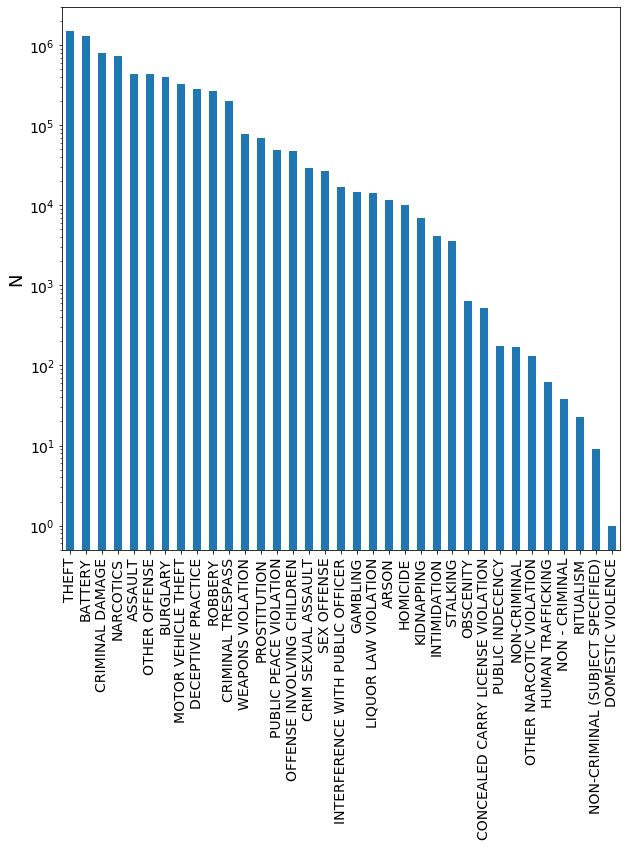

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
crimedata['Primary Type'].value_counts().plot(kind='bar', ax=ax)
ax.set_yscale('log')
ax.set_ylabel('N', fontsize=18)
ax.tick_params(labelsize=14)

So, thefts are the most common crime, followed by battery. This is not terribly surprising. Of, say, thefts, what are the most common descriptors?

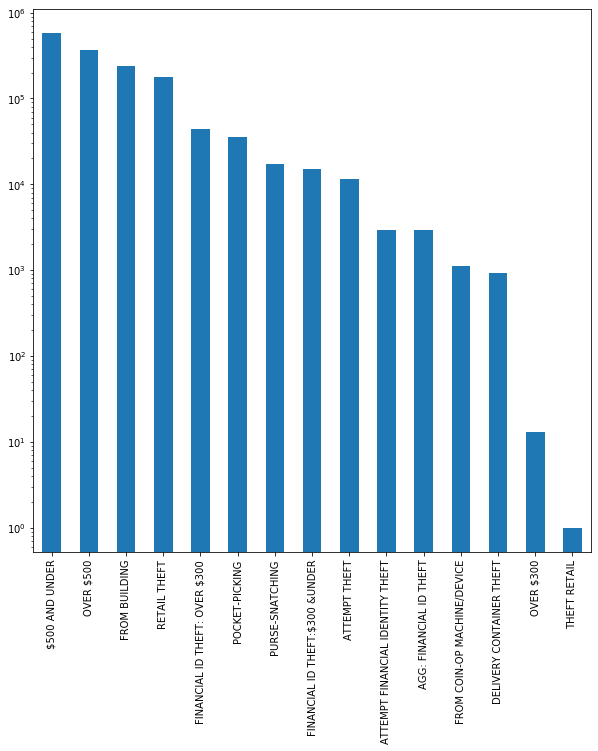

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
crimedata[crimedata['Primary Type'] == 'THEFT']['Description'].value_counts().plot(kind='bar', ax=ax)
ax.set_yscale('log')

The most common theft description is \\$500 and under, followed by over \\$500; small amounts are more common than large. For Financial ID Theft, however, it is the other way around, with higher amounts more common.

That last "theft retail" appears to be an error; "retail theft" is a much more common descriptor.

# Crimes as a function of time and date

Some assumptions certainly go into the believability of these plots.
For example:
* Listed information---particularly dates and times---are accurate (the overabundance of crimes on the first of the month casts doubt on this assumption)

Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: hour
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: weekday
Unrecognized weights: year
Unrecognized weights: year
Unrecognized weights: year
Unrecognized weights: year
Unrecognized weights: year


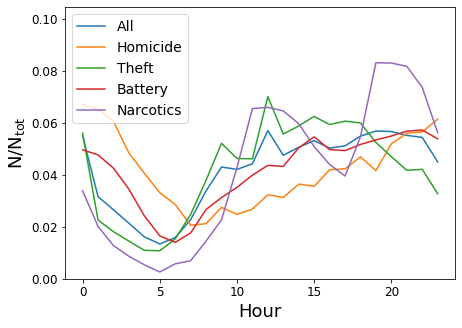

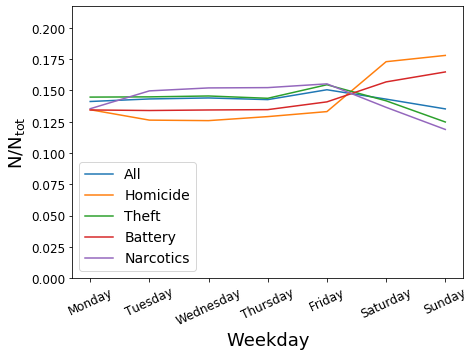

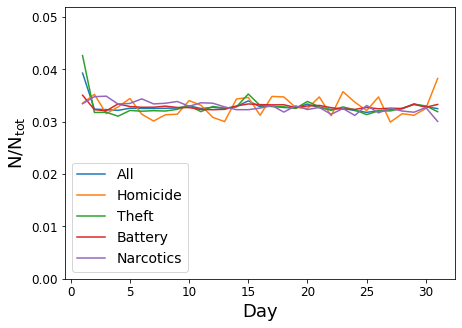

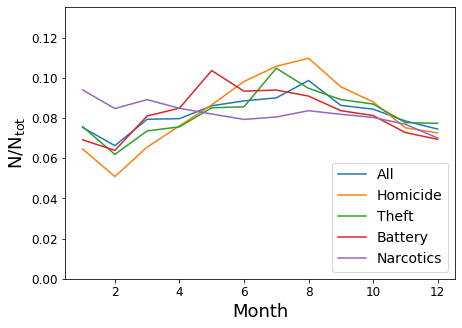

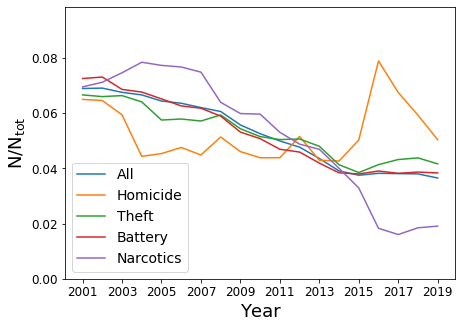

In [14]:
for time_interval in crime_counts['all']:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)
    for crime_type, color in zip(crime_counts, [f'C{i}' for i in range(len(crime_counts))]):
        plot_counts(crime_counts[crime_type][time_interval], ax, weights=time_interval, bar=False, do_err=False,
                    label=crime_type.capitalize(), color=color,)# alpha=1./len(crime_counts),)
#                     hatch=hatch)
    ax.legend(loc='best', fontsize=14)
    ax.set_xlabel(time_interval.capitalize(), fontsize=18)
    ax.set_ylabel('N/N$_\mathrm{tot}$', fontsize=18)
    ax.set_ylim([0, ax.set_ylim()[-1] * 1.2])
    ax.tick_params(labelsize=12)
    if time_interval == 'year':
        ax.set_xticklabels([str(year) for year in np.arange(2001, 2021, 2)])
        ax.set_xticks(np.arange(2001, 2021, 2))
    if time_interval == 'weekday':
        ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                          rotation=25)
        ax.set_xticks(np.arange(7))

A few interesting things to note here. Crimes generally seem to be least frequent around 5 AM, while homicides bottom out around 7 AM. Homicides also seem to peak a bit later than most crimes. Thefts, on the other hand, peak in the afternoon (except for a single spike around noon, which I will assume for now comes from thefts around the lunch hour. To test this I should see which specific types of theft are contributing to the spike). All of these observations are consistent with a general idea that most crimes require people to be around, while homicides occur when people *aren't* around.

There aren't strong trends with day of the week, except for a weekday/weekend divide. Homicides are less common on weekdays and more common on weekends, while other crimes are generally more common during the week. Future work will require separating crimes geographically. How much of this trend comes from crimes being concentrated in business areas?

For day of the month, I have weighted the histograms so that long months have their extra days' counts proportionately increased. With the exception of the first and last day of the month, variations look like noise. I assume (for now) that the differences in the first/last days are reporting biases of some sort.

For month of year, I have also weighted months by their length, so I have upweighted February and downweighted long months.

Crime generally has gone down over the last 19 years, almost by a factor of 2. The decline may be leveling, however. Starting in 2015, as well, murders spiked significantly, though perhaps they are returning again to their previous levels.

# Where do crimes occur?

In [15]:
geodf = geopandas.read_file(geofilename)
geodf['area_num_1'] = geodf['area_num_1'].astype(int)

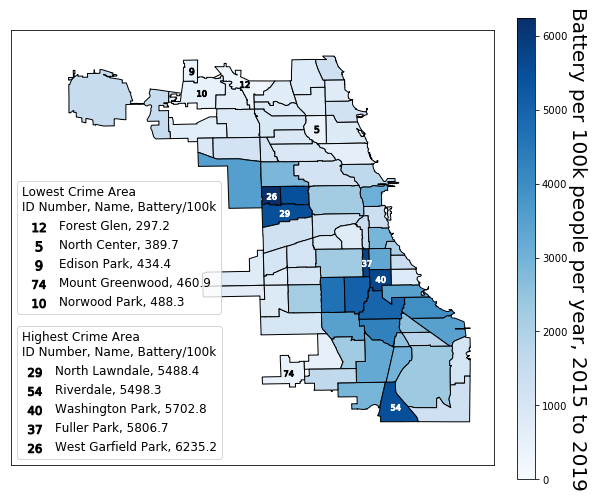

In [16]:
plot_crime_map(crimedata, geodf, census_dat, (2015, 2019), 'battery', cmap='Blues', 
               annotate=True, num_annotations=(5, 5), annot_colors=('black', 'white'))

Looks like homicides are very inhomogenously distributed; a few neighborhoods on the South and West sides have the majority of homicides. Most chicago neighborhoods have very low incidence of homicide. Thefts, on the other hand, are another matter:

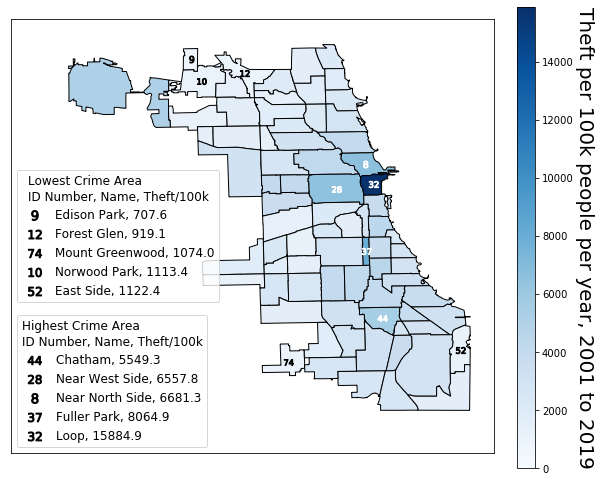

In [17]:
plot_crime_map(crimedata, geodf, census_dat, (2001, 2019), 'theft', cmap='Blues', 
               annotate=True, num_annotations=(5, 5), annot_colors=('black', 'white'))

By a huge margin, the highest rate of theft is in the Loop, which is Chicago's most important commercial center. We can see in the list of descriptions below that, unlike what we saw above, the most common thefts are From Building and Retail Theft. This makes sense, given the nature of the neighborhood. We can also probably safely assume that such a commercial area is not only subject to more thefts, but is also more diligent in reporting them. Finally, the rate (per 100k people) is based on census data, but a commercial area like the Loop likely has far more people working there than residing there, which would inflate the rate.

In [18]:
crimedata[(crimedata['Primary Type'] == 'THEFT') 
          & (crimedata['Community Area'] == 32)]['Description'].value_counts()

FROM BUILDING                       22903
RETAIL THEFT                        18993
$500 AND UNDER                      18589
OVER $500                           16148
POCKET-PICKING                       9040
FINANCIAL ID THEFT: OVER $300         869
PURSE-SNATCHING                       697
ATTEMPT THEFT                         646
FINANCIAL ID THEFT:$300 &UNDER        291
ATTEMPT FINANCIAL IDENTITY THEFT      104
FROM COIN-OP MACHINE/DEVICE            46
AGG: FINANCIAL ID THEFT                45
DELIVERY CONTAINER THEFT                7
OVER $300                               2
Name: Description, dtype: int64

In [19]:
# uncomment to make figures for every year
# for year in np.arange(2001, 2020, 1):
#     plot_crime_map(crimedata, geodf, census_dat, year, 'homicide', cmap='Blues', 
#                annotate=False, filename=f'figures/homicide_map_{year}.png', vmax=150)

# What is the periodicity of crime?

Below is a plot of the estimated [power spectral density (PSD)](https://en.wikipedia.org/wiki/Spectral_density) of all crimes in Chicago over the 19 year time period in the dataset (Technically, this is a modified [periodogram](https://en.wikipedia.org/wiki/Periodogram) constructed using [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)).

The peaks are places where there is more periodicity in the signal. Almost every crime has its highest peak at the frequency coinciding with a once-per-year frequency. This is not surprising, given what we saw in the plots of crimes as a function of time --- they seem to increase in summer and decrease in winter in a periodic way. Things that have weekly periodicity could result from a routine weekend/weekday divide.

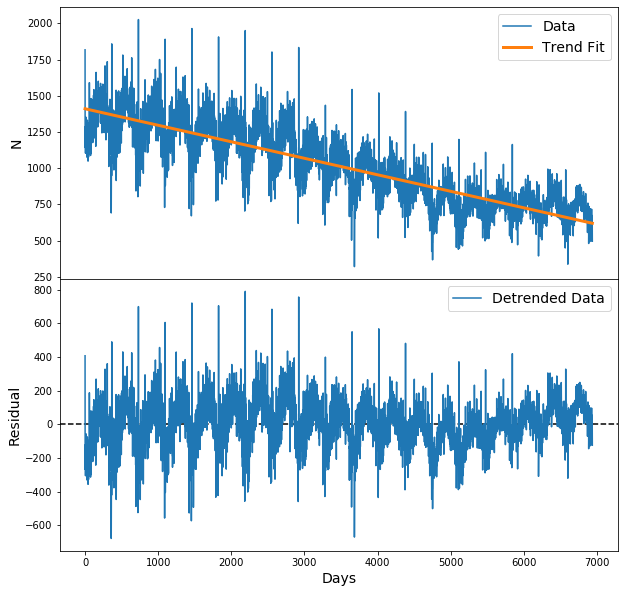

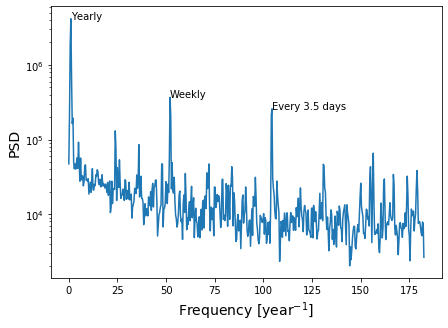

In [20]:
crime_periodogram(crimedata, crime_type='all', plot_trends=True)

It's interesting to note that the highest peak for in the PSD of narcotics posession is not yearly. This was hinted at above as well -- there is no seasonal variation in narcotics crimes.

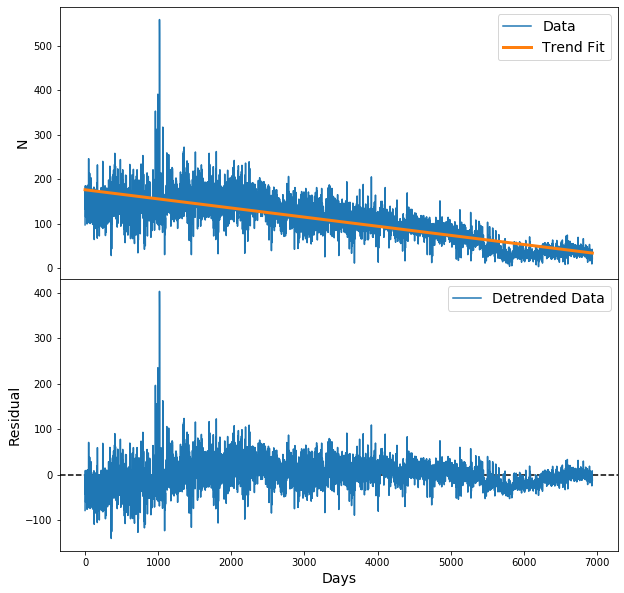

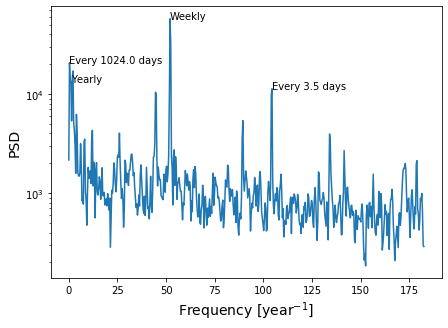

In [21]:
crime_periodogram(crimedata, crime_type='narcotics', plot_trends=True)

## NOT DONE

In [22]:
def gaussian(x, mu, sigma):
    x = np.array(x)
    return 1. / np.sqrt((2 * np.pi * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma))

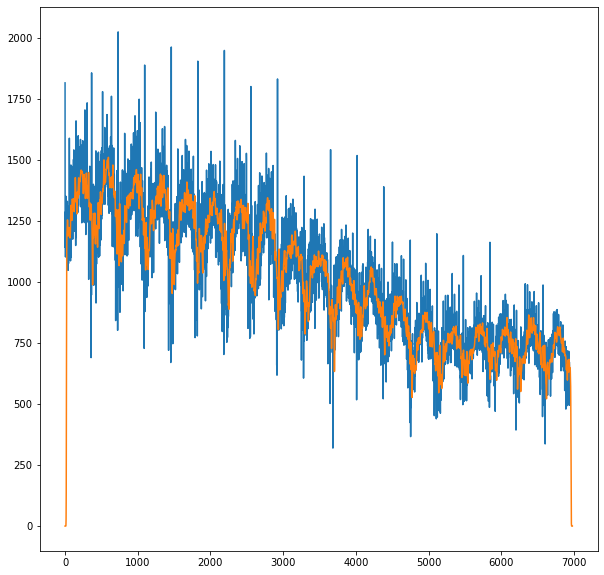

In [23]:
crime_days = (crimedata.index - pd.to_datetime('Jan 01 2001')).days.value_counts().sort_index()
plt.figure(figsize=(10, 10))
plt.plot(crime_days)
plt.plot(np.convolve(crime_days, gaussian(np.arange(-20, 20, 1), 0, 7))) #gaussian smoothing with 1 week sigma